In [35]:
import matplotlib.pyplot as plt
import celluloid
import torch
from IPython.core.display import HTML



In [36]:
BATCH, CLASS, EPOCHS, FEATS = 100, 10, 2, 2

X = torch.rand(BATCH, FEATS + 1)
X[:, -1] = 1 # bias
y = (X.sum(dim = 1) > 2).long() # if x[0] + x[1] > 1.. its label is 1

# i'm effectively learning "if x1 + x2 > 1"

In [37]:
w = torch.zeros(FEATS + 1, CLASS, requires_grad = True)
opt = torch.optim.LBFGS([w]) # optimizer

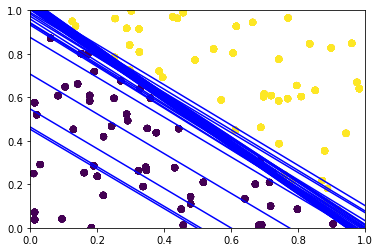

In [38]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
camera = celluloid.Camera(fig)

for _ in range(EPOCHS):
    def loss():
        # need to max log p(y) wrt weights w
        # p(y_i | x_i) = Multinomial(softmax(w.T @ x_i)) # CLASS dim prob dist 
        # y = [0...1..0] where 1 is at its class k
        # p(y) = p_1 ^ y_1 * p_2 ^ y_2 * ... * p_K ^ y_K
        # log p(y) = sum y_k * log p_k
        # --> we retain log p_k of any one of the sums... based on one-hot y
        
        out = (X @ w).log_softmax(dim = 1)
        out = -out[torch.arange(BATCH,), y].mean() # retain based on one-hot
        # minus because we consider "minimizing -logp(y) == maximising log p(y)" 
        
#         (w.grad, ) = torch.autograd.grad(out, w) # send those grads back.. why not. out.backward()
        out.backward()
        
        # plotting
        ax.scatter(X[:, 0], X[:, 1], c = y)
        
        # for a point x to belong to class 0 ..we care about x @ w[:, 0]
        # ie, x1 * a_0 + x2 * b_0 + c_0 (where w[:, 0] = [a_0, b_0, c_0], x = [x1, x2, 1]) 
        # for point to belong to class 1 .. x1 * a_1 + x2 * b_1 + c_1
        # the middle-ground line is when x1a0 + x2b0 + c0 = x1a1 + x2b1 + c1
        # so x2 = -(a0 - a1)/(b0 - b1) * x1 + (c0 - c1)/(b0 - b1) ... thats where w2 comes from
        w2 = (w[:, 0] - w[:, 1]).detach()
        xs = torch.linspace(0, 1.0, 100)
        ax.plot(xs, (-xs * (w2[0] / w2[1]) - (w2[2] / w2[1])), color = "blue")
        camera.snap()
        
        return out
    
    opt.step(loss)


In [39]:
HTML(camera.animate().to_jshtml())